## CS441: Applied ML - HW 4

### Part 1: Model Complexity and Tree-based Regressors

One measure of a tree’s complexity is the maximum tree depth. Train tree, random forest, and boosted tree regressors on the temperature regression task, using all default parameters except:


*   max_depth={2,4,8,16,32}
*   random_state=0
*   For random forest: max_features=1/3

Measure train and val RMSE for each and plot them all on the same plot using the provided plot_depth_error function. You should have six lines (train/val for each model type), each with 5 data points (one for each max depth value).  Include the plot and answer the analysis questions in the report.

In [ ]:
import numpy as np
from google.colab import drive
%matplotlib inline
from matplotlib import pyplot as plt

# load data (modify to match your data directory or comment)
def load_temp_data():
  drive.mount('/content/drive')
  datadir = "/content/drive/My Drive/Colab Notebooks/"
  T = np.load(datadir + 'temperature_data.npz')
  x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day = \
  T['x_train'], T['y_train'], T['x_val'], T['y_val'], T['x_test'], T['y_test'], T['dates_train'], T['dates_val'], T['dates_test'], T['feature_to_city'], T['feature_to_day']
  return (x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day)

# plot one data point for listed cities and target temperature
def plot_temps(x, y, cities, feature_to_city, feature_to_day, target_date):
  nc = len(cities)
  ndays = 5
  xplot = np.array([-5,-4,-3,-2,-1])
  yplot = np.zeros((nc,ndays))
  for f in np.arange(len(x)):
    for c in np.arange(nc):
      if cities[c]==feature_to_city[f]:
        yplot[feature_to_day[f]+ndays,c] = x[f]
  plt.plot(xplot,yplot)
  plt.legend(cities)
  plt.plot(0, y, 'b*', markersize=10)
  plt.title('Predict Temp for Cleveland on ' + target_date)
  plt.xlabel('Day')
  plt.ylabel('Avg Temp (C)')
  plt.show()

# load data
(x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day) = load_temp_data()

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# to plot the errors
def plot_depth_error(max_depths, tree_train_err, tree_val_err, rf_train_err, rf_val_err, bt_train_err, bt_val_err):
  plt.figure()
  plt.semilogx(max_depths, tree_train_err, 'r.--',label='tree train')
  plt.semilogx(max_depths, tree_val_err, 'r.-', label='tree val')
  plt.semilogx(max_depths, rf_train_err, 'g.--',label='RF train')
  plt.semilogx(max_depths, rf_val_err, 'g.-', label='RF val')
  plt.semilogx(max_depths, bt_train_err, 'b.--',label='BT train')
  plt.semilogx(max_depths, bt_val_err, 'b.-', label='BT val')
  plt.ylabel('RMSE Error')
  plt.xlabel('Max Tree Depth')
  plt.xticks(max_depths, max_depths)
  plt.legend()
  plt.rcParams.update({'font.size': 20})
  plt.show()

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

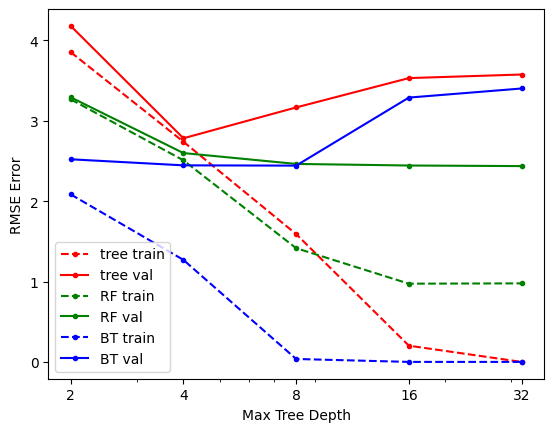

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

max_depths = [2,4,8,16,32]

tree_train_err, tree_val_err = [], []
rf_train_err, rf_val_err = [], []
bt_train_err, bt_val_err = [], []
# usage examples
# model = DecisionTreeRegressor(random_state=0, max_depth=max_depths)
for max_depth in max_depths:
  tree_model = DecisionTreeRegressor(random_state=0, max_depth=max_depth)
  tree_model.fit(x_train, y_train)
  tree_train_err.append(np.sqrt(mean_squared_error(y_train, tree_model.predict(x_train))))
  tree_val_err.append(np.sqrt(mean_squared_error(y_val, tree_model.predict(x_val))))

  rf_model = RandomForestRegressor(random_state=0, max_depth=max_depth, max_features=1/3)
  rf_model.fit(x_train, y_train)
  rf_train_err.append(np.sqrt(mean_squared_error(y_train, rf_model.predict(x_train))))
  rf_val_err.append(np.sqrt(mean_squared_error(y_val, rf_model.predict(x_val))))

  # Train GradientBoostingRegressor
  bt_model = GradientBoostingRegressor(random_state=0, max_depth=max_depth)
  bt_model.fit(x_train, y_train)
  bt_train_err.append(np.sqrt(mean_squared_error(y_train, bt_model.predict(x_train))))
  bt_val_err.append(np.sqrt(mean_squared_error(y_val, bt_model.predict(x_val))))

# Plot the RMSE for each model
plot_depth_error(max_depths, tree_train_err, tree_val_err, rf_train_err, rf_val_err, bt_train_err, bt_val_err)

# model = RandomForestRegressor(random_state=0, max_depth=max_depth, max_features=1/3)
# model = GradientBoostingRegressor(random_state=0, max_depth=max_depth)



### Part 2: MLPs with MNIST

For this part, you will want to use a GPU to improve runtime. Google Colab provides limited free GPU acceleration to all users. Go to Runtime and change Runtime Type to GPU.  This will reset your compute node, so do it before starting to run other cells.

See [Tips](https://docs.google.com/document/d/1_kV9x1LCAFfe6UqY22eqj2eqdCZh72oQDf60zRo2ydM/edit?usp=drive_link) for detailed guidance on this problem.

First, use PyTorch to implement a Multilayer Perceptron network with one hidden layer (size 64) with ReLU activation. Set the network to minimize cross-entropy loss, which is the negative log probability of the training labels given the training features. This objective function takes unnormalized logits as inputs.

*Do not use MLP in sklearn for this HW - use Torch*.

In [ ]:
# initialization code
import numpy as np
from keras.datasets import mnist
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats
import torch
import torch.nn as nn

def load_mnist():
  '''
  Loads, reshapes, and normalizes the data
  '''
  (x_train, y_train), (x_test, y_test) = mnist.load_data() # loads MNIST data
  x_train = np.reshape(x_train, (len(x_train), 28*28))  # reformat to 768-d vectors
  x_test = np.reshape(x_test, (len(x_test), 28*28))
  maxval = x_train.max()
  x_train = x_train/maxval  # normalize values to range from 0 to 1
  x_test = x_test/maxval
  return (x_train, y_train), (x_test, y_test)

def display_mnist(x, subplot_rows=1, subplot_cols=1):
  '''
  Displays one or more examples in a row or a grid
  '''
  if subplot_rows>1 or subplot_cols>1:
    fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(15,15))
    for i in np.arange(len(x)):
      ax[i].imshow(np.reshape(x[i], (28,28)), cmap='gray')
      ax[i].axis('off')
  else:
      plt.imshow(np.reshape(x, (28,28)), cmap='gray')
      plt.axis('off')
  plt.show()

In [ ]:
# Sets device to "cuda" if a GPU is available  (in Colabs, enable GPU by Edit->Notebook Settings-->Hardware Accelerator=GPU)
device = "cuda" if torch.cuda.is_available() else 'cpu'
print(device) # make sure you're using GPU instance

cuda


#### 2a
Using the train/val split provided in the starter code, train your network for 100 epochs with learning rates of 0.01, 0.1, and 1.  Use a batch size of 256 and the SGD optimizer.  After each epoch, record the mean training and validation loss and compute the validation error of the final model. The mean validation loss should be computed after the epoch is complete.  The mean training loss can either be computed after the epoch is complete, or, for efficiency, computed using the losses accumulated during the training of the epoch.  Plot the training and validation losses using the display_error_curves function.

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
(x_train, y_train), (x_test, y_test) = load_mnist()

# create train/val split
ntrain = 50000
x_val = x_train[ntrain:].copy()
y_val = y_train[ntrain:].copy()
x_train = x_train[:ntrain]
y_train = y_train[:ntrain]

In [ ]:
def display_error_curves(training_losses, validation_losses):
  """
  Plots the training and validation loss curves
  training_losses and validation_losses should be lists or arrays of the same length
  """
  num_epochs = len(training_losses)

  plt.plot(range(num_epochs), training_losses, label="Training Loss")
  plt.plot(range(num_epochs), validation_losses, label="Validation Loss")

  # Add in a title and axes labels
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  # Display the plot
  plt.legend(loc='best')
  plt.show()

In [ ]:
# Define the model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        # Needs code here
        self.layers= nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
      # Needs code here
        return self.layers(x)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Define the model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.layers= nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.layers(x)
def train_MLP_mnist(train_loader, val_loader, lr=1e-1, num_epochs=100):
  input_size = 28*28
  hidden_size = 64
  output_size = 10

  # Instantiate the model
  mlp = MLP(input_size, hidden_size, output_size).to(device)

  # Define loss function and optimizer
  loss_function = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(mlp.parameters(), lr=lr)

  # Train the model, compute and store train/val loss at each epoch
  training_losses = []
  validation_losses = []

  for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
      inputs, targets = data
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = mlp(inputs)
      loss = loss_function(outputs, targets)
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()

    training_losses.append(running_loss / len(train_loader))

    # Compute validation loss
    val_loss, _ = evaluate_MLP(mlp, val_loader)
    validation_losses.append(val_loss)

  # Display Loss Curves
  display_error_curves(training_losses, validation_losses)

  return mlp

def evaluate_MLP(mlp, loader):
  N = 0
  acc = 0
  loss = 0
  loss_function = torch.nn.CrossEntropyLoss()
  with torch.set_grad_enabled(False):
    for i, data in enumerate(loader, 0):
      inputs, targets = data
      inputs, targets = inputs.to(device), targets.to(device)
      N += len(targets)

      # Perform forward pass
      outputs = mlp(inputs)

      # Compute sum of correct labels
      y_pred = torch.argmax(outputs, dim=1)
      targets = torch.argmax(targets, dim=1)  # Convert one-hot encoded targets to class indices
      acc += torch.sum(y_pred==targets).item()

      # Compute loss
      loss += loss_function(outputs, targets).item()*len(targets)

  loss /= N
  acc /= N

  return loss, 1-acc


# # Train the model
# mlp = train_MLP_mnist(train_dl, val_dl, lr=1.5E-3, num_epochs=100)


train_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_train),torch.Tensor(np.eye(10)[y_train]))
val_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_val),torch.Tensor(np.eye(10)[y_val]))
test_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_test),torch.Tensor(np.eye(10)[y_test]))


# Create DataLoaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



# Learning rates to experiment with
# learning_rates = [0.001, 0.01, 0.1, 1]
learning_rates = [1.5E-3]


# Loop through the learning rates, training the model for each one
for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")

    # Ensure the model is re-initialized for each learning rate
    mlp = MLP(28*28, 64, 10).to(device)

    # Train the model
    trained_mlp = train_MLP_mnist(train_loader, val_loader, lr=lr, num_epochs=100)

    # Evaluate the trained model on the validation set
    val_loss, val_error = evaluate_MLP(trained_mlp, val_loader)
    print(f"Learning Rate: {lr}, Validation Loss: {val_loss:.4f}, Validation Error: {val_error:.4f}")

    train_loss, train_error = evaluate_MLP(trained_mlp, train_loader)
    print(f"Learning Rate: {lr}, train Loss: {val_loss:.4f}, train Error: {val_error:.4f}")

    test_loss, test_error = evaluate_MLP(trained_mlp, test_loader)
    print(f"Learning Rate: {lr}, test Loss: {val_loss:.4f}, test Error: {val_error:.4f}")




In [ ]:
# Code for running experiments

print(device) # make sure you're using GPU instance
torch.manual_seed(0) # to avoid randomness, but if you wanted to create an ensemble, you should not use a manual seed

# TODO (set up dataloaders, and call training function)
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# # Convert the NumPy arrays to PyTorch tensors and flatten the input images
# x_train_tensor = torch.tensor(x_train.reshape(-1, 28*28), dtype=torch.float)
# y_train_tensor = torch.tensor(y_train, dtype=torch.long)
# x_val_tensor = torch.tensor(x_val.reshape(-1, 28*28), dtype=torch.float)
# y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# # Create TensorDatasets
# train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
# val_dataset = TensorDataset(x_val_tensor, y_val_tensor)


train_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_train),torch.Tensor(np.eye(10)[y_train]))

val_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_val),torch.Tensor(np.eye(10)[y_val]))

# Create DataLoaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Seed for reproducibility
torch.manual_seed(0)

# Learning rates to experiment with
learning_rates = [0.001, 0.01, 0.1, 1]

# Loop through the learning rates, training the model for each one
for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")

    # Ensure the model is re-initialized for each learning rate
    mlp = MLP(28*28, 64, 10).to(device)

    # Train the model
    trained_mlp = train_MLP_mnist(train_loader, val_loader, lr=lr, num_epochs=100)

    # Evaluate the trained model on the validation set
    val_loss, val_error = evaluate_MLP(trained_mlp, val_loader)
    print(f"Learning Rate: {lr}, Validation Loss: {val_loss:.4f}, Validation Error: {val_error:.4f}")

In [ ]:
!nvidia-smi

In [ ]:
# TO DO (retrain if needed, and evaluate model on train, val, and test sets)

#for 1.5E-3 error
def train_and_evaluate_MLP(train_loader, val_loader, test_loader, lr=1e-1, num_epochs=100):
  input_size = 28*28
  hidden_size = 64
  output_size = 10

  # Instantiate the model
  mlp = MLP(input_size, hidden_size, output_size).to(device)

  # Define loss function and optimizer
  loss_function = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(mlp.parameters(), lr=lr)

  # Train the model, compute and store train/val loss at each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
      inputs, targets = data
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = mlp(inputs)
      targets = torch.argmax(targets, dim=1)  # Convert one-hot encoded targets to class indices
      loss = loss_function(outputs, targets)
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()

  # Compute training loss and error
  train_loss, train_error = evaluate_MLP(mlp, train_loader)
  print(f'Training Loss: {train_loss:.1E}')
  print(f'Training Error (%): {train_error*100:.2f}')

  # Compute validation loss and error
  val_loss, val_error = evaluate_MLP(mlp, val_loader)
  print(f'Validation Loss: {val_loss:.1E}')
  print(f'Validation Error (%): {val_error*100:.2f}')

  # Compute test loss and error
  test_loss, test_error = evaluate_MLP(mlp, test_loader)
  print(f'Test Loss: {test_loss:.1E}')
  print(f'Test Error (%): {test_error*100:.2f}')

  return mlp

# Create dataloaders
train_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_train),torch.Tensor(np.eye(10)[y_train]))
train_dl = DataLoader(train_dataset, batch_size=256, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_val),torch.Tensor(np.eye(10)[y_val]))
val_dl = DataLoader(val_dataset, batch_size=256 * 2)

test_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_test),torch.Tensor(np.eye(10)[y_test]))
test_dl = DataLoader(test_dataset, batch_size=256 * 2)

# Train the model and report losses and errors
mlp = train_and_evaluate_MLP(train_dl, val_dl, test_dl, lr=1.5E-3, num_epochs=100)

## Part 3: Predicting Penguin Species

Include all your code for part 3 in this section.  

In [ ]:
import numpy as np
from google.colab import drive
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
#styling preferences for sns
sns.set_style('whitegrid')
sns.set_context('poster')
drive.mount('/content/gdrive/')
datadir = "/content/gdrive/MyDrive/Colab Notebooks/"
df_penguins = pd.read_csv(datadir + 'penguins_size.csv')
df_penguins.head(10)

# convert features with multiple string values to binary features so they can be used by sklearn
def get_penguin_xy(df_penguins):
  data = np.array(df_penguins[['island', 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']])
  y = df_penguins['species']
  ui = np.unique(data[:,0]) # unique island
  us = np.unique(data[:,-1]) # unique sex
  X = np.zeros((len(y), 10))
  for i in range(len(y)):
    f = 0
    for j in range(len(ui)):
      if data[i, f]==ui[j]:
        X[i, f+j] = 1
    f = f + len(ui)
    X[i, f:(f+4)] = data[i, 1:5]
    f=f+4
    for j in range(len(us)):
      if data[i, 5]==us[j]:
        X[i, f+j] = 1
  feature_names = ['island_biscoe', 'island_dream', 'island_torgersen', 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex_female', 'sex_male', 'sex_unknown']
  X = pd.DataFrame(X, columns=feature_names)
  return(X, y, feature_names, np.unique(y))

Mounted at /content/gdrive/


#### 3a
Spend some time to visualize different pairs of features and their relationships to the species.  We’ve done one for you.  Include in your report at least two other visualizations.

In [ ]:
def plot_scatter(feature1, feature2):
  '''
  Provide names of two features to create a scatterplot of them
  E.g. plot_scatter('culmen_length_mm', 'culmen_depth_mm')
  Possible features: 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g'
  '''

  palette = ["red", "blue", "orange"]

  sns.scatterplot(data=df_penguins, x = feature1, y = feature2,
               hue = 'species', palette=palette, alpha=0.8)
  # Doc: https://seaborn.pydata.org/generated/seaborn.scatterplot.html

  plt.xlabel(feature1, fontsize=14)
  plt.ylabel(feature2, fontsize=14)
  plt.title(feature1 + ' vs ' + feature2, fontsize=20)
  plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
  plt.show()

# TO DO call plot_scatter with different feature pairs to create some visualizations

# Plotting 'culmen_length_mm' vs 'body_mass_g'
plot_scatter('culmen_depth_mm', 'flipper_length_mm')

# Plotting 'flipper_length_mm' vs 'culmen_depth_mm'
plot_scatter('flipper_length_mm', 'culmen_length_mm')

plot_scatter('flipper_length_mm', 'body_mass_g')

NameError: name 'sns' is not defined

#### 3b
Suppose you want to be able to identify the Gentoo species with a simple rule with very high accuracy.  Use a decision tree classifier to figure out such a rule that has only two checks (e.g. “mass greater than 4000 g, and culmen length less than 40 mm is Gentoo; otherwise, not”).   You can use the library DecisionTreeClassifier with either ‘gini’ or ‘entropy’ criterion. Use sklearn.tree.plot_tree with feature_names and class_names arguments to visualize the decision tree.  Include the tree that you used to find the rule in your report and the rule.

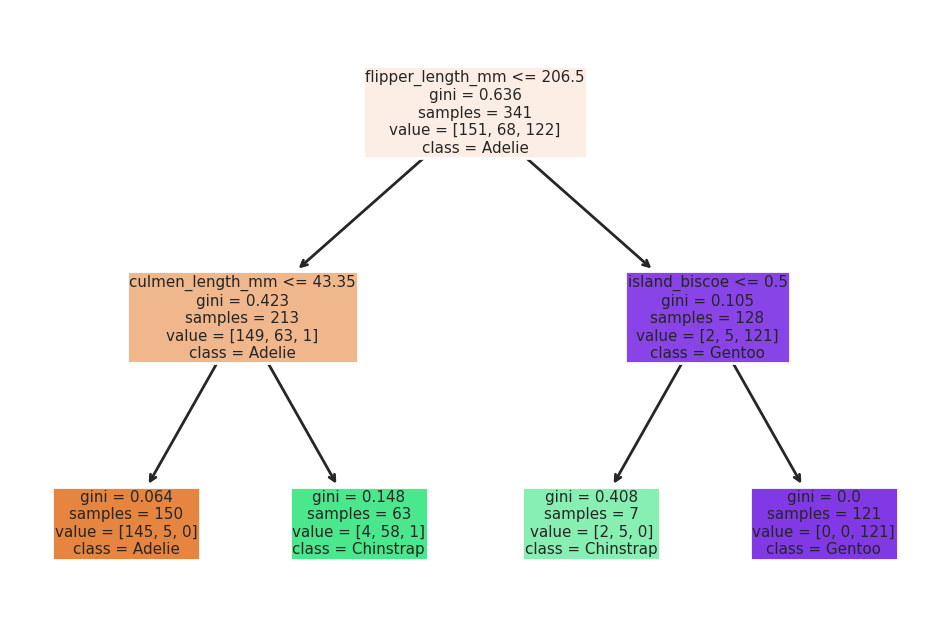

Gentoo Precision: 1.0
Gentoo Recall: 1.0


In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Prepare the data
X, y, feature_names, class_names = get_penguin_xy(df_penguins)

# Create and fit the classifier
clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X, y)

# Plot the tree
plt.figure(figsize=(12,8))
plot_tree(clf, feature_names=feature_names, class_names=class_names, filled=True)
plt.show()

# Make predictions
y_pred = clf.predict(X_test)

# Generate a classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Extract precision and recall for the Gentoo species
gentoo_precision = report['Gentoo']['precision']
gentoo_recall = report['Gentoo']['recall']

print(f'Gentoo Precision: {gentoo_precision}')
print(f'Gentoo Recall: {gentoo_recall}')

#### 3c

Use any method at your disposal to achieve maximum 5-fold cross-validation accuracy on this problem. To keep it simple, we will use sklearn.model_selection to perform the cross-validation for us. Report your model design and 5-fold accuracy.  It is possible to get more than 99% accuracy.

In [ ]:
# design a classification model, import libraries as needed
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

X, y, feature_names, class_names = get_penguin_xy(df_penguins)

# TO DO -- choose some model and fit the data
model = RandomForestClassifier(n_estimators=100, random_state=42)

scores = cross_val_score(model, np.array(X), np.array(y), cv=5)
print('CV Accuracy: {}'.format(scores.mean()))



## Part 4: Stretch Goals
Include any new code needed for Part 4 here

In [ ]:
# TO DO (optional)


import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

# Load the data
(x_train, y_train), (x_test, y_test) = load_mnist()

# Split the training data into a training set and a validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
x_train, y_train = torch.from_numpy(x_train), torch.from_numpy(y_train)
x_val, y_val = torch.from_numpy(x_val), torch.from_numpy(y_val)
x_test, y_test = torch.from_numpy(x_test), torch.from_numpy(y_test)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x

# Create the model
model = MLP()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# Train the model
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(x_train.float())
    loss = criterion(outputs, y_train.long())
    loss.backward()
    optimizer.step()
    scheduler.step()

# Calculate validation error
with torch.no_grad():
    outputs = model(x_val.float())
    _, predicted = torch.max(outputs.data, 1)
    val_error = 1 - accuracy_score(y_val, predicted)

print('Validation error: {:.2f}%'.format(val_error * 100))

# Calculate test error
with torch.no_grad():
    outputs = model(x_test.float())
    _, predicted = torch.max(outputs.data, 1)
    test_error = 1 - accuracy_score(y_test, predicted)

print('Test error: {:.2f}%'.format(test_error * 100))

In [ ]:
#question 2 is the stretch goal challenge
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load and resize the image

drive.mount('/content/drive')

# Specify the path to your image
image_path = "/content/drive/My Drive/Colab Notebooks/scotland_photo.jpg"

image = Image.open(image_path)
image = image.resize((64, 64))
image_data= np.array(image) / 255.0



# Create sinusoidal positional encodings
def create_positional_encoding(dim, length):
    positional_encoding = np.zeros((length, dim))
    for pos in range(length):
        for i in range(0, dim, 2):
            positional_encoding[pos, i] = np.sin(pos / (10000 ** ((2 * i) / dim)))
            if i + 1 < dim:
                positional_encoding[pos, i + 1] = np.cos(pos / (10000 ** ((2 * i) / dim)))
    return positional_encoding

# Create MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

# Prepare data
encoding_dim = 16
positional_encodings = create_positional_encoding(encoding_dim, 64)
X = []
y = []
for i in range(64):
    for j in range(64):
        encoding = np.concatenate((positional_encodings[i], positional_encodings[j]))
        X.append(encoding)
        y.append(image_data[i, j])
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Train MLP
mlp = MLP(encoding_dim * 2, 256, 3)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.01)
for epoch in range(5000):
    optimizer.zero_grad()
    outputs = mlp(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

# Generate and display the image
generated_image = mlp(X).detach().numpy().reshape(64, 64, 3)
plt.imshow(generated_image)
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


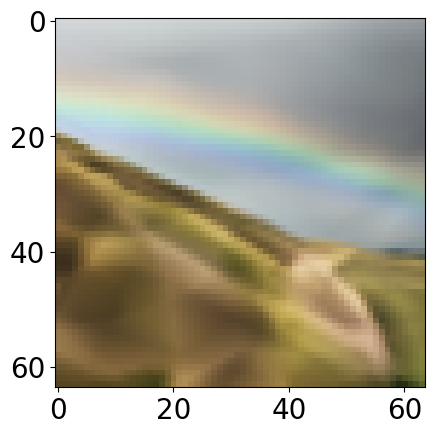

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define the MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)
drive.mount('/content/drive')

# Specify the path to your image
image_path = "/content/drive/My Drive/Colab Notebooks/scotland_photo.jpg"

image = Image.open(image_path)
image = image.resize((64, 64))
image_data= np.array(image) / 255.0

# Create the positional encodings
X = []
y = []
for i in range(64):
    for j in range(64):
        X.append([i / 64.0, j / 64.0])  # Normalize to [0, 1]
        y.append(image_data[i, j])

X = torch.Tensor(X)
y = torch.Tensor(y)

# Create the MLP
mlp = MLP(2, 256, 3)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters())

# Train the MLP
for epoch in range(5000):
    optimizer.zero_grad()
    outputs = mlp(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

# Generate the image
generated_image_data = mlp(X).detach().numpy()
generated_image = (generated_image_data * 255).astype(np.uint8).reshape(64, 64, 3)

# Display the image using matplotlib
plt.imshow(generated_image)
plt.show()

In [ ]:
# from https://gist.github.com/jonathanagustin/b67b97ef12c53a8dec27b343dca4abba
# install can take a minute

import os
# @title Convert Notebook to PDF. Save Notebook to given directory
NOTEBOOKS_DIR = "/content/drive/My Drive/Colab Notebooks/" # @param {type:"string"}
NOTEBOOK_NAME = "Copy of CS441_SP24_HW4_Starter.ipynb" # @param {type:"string"}
#------------------------------------------------------------------------------#
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
NOTEBOOK_PATH = f"{NOTEBOOKS_DIR}/{NOTEBOOK_NAME}"
assert os.path.exists(NOTEBOOK_PATH), f"NOTEBOOK NOT FOUND: {NOTEBOOK_PATH}"
!apt install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic > /dev/null 2>&1
!jupyter nbconvert "$NOTEBOOK_PATH" --to pdf > /dev/null 2>&1
NOTEBOOK_PDF = NOTEBOOK_PATH.rsplit('.', 1)[0] + '.pdf'
assert os.path.exists(NOTEBOOK_PDF), f"ERROR MAKING PDF: {NOTEBOOK_PDF}"
print(f"PDF CREATED: {NOTEBOOK_PDF}")

Mounted at /content/drive/
PDF CREATED: /content/drive/My Drive/Colab Notebooks//Copy of CS441_SP24_HW4_Starter.pdf
